# Try DAPS on demo datasets with different diffusion models.

This notebook provides a walkthrough of the fundamental modules of DAPS and evaluates its performance on demo datasets using different diffusion models, including the Pixel Diffusion Model, the Latent Diffusion Model (LDM), and text-conditioned Stable Diffusion (SD) models.

## 0. Setup
Notice: we **highly recommend** to use local runtime by following [README](https://github.com/zhangbingliang2019/DAPS) to setup environment. **Please, make sure you are running in DAPS folder.**

If you still want to setup the environment on the cloud. Unconment and Run following cell to install requirements. If prompted with restart session, just restart and rerun the cell.

In [ ]:
# !git clone https://github.com/zhangbingliang2019/DAPS.git
# %cd /content/DAPS/
# !pip install -r requirements.txt

## 1. Prepare dataset, task and diffusion config.
This scripts support all three types of diffusion model,
* Pixel Diffusion (ADM),
* Latent Diffusion (LDM),
* Stable Diffusion (sd v1.5),

and 8 tasks (5 linear and 3 nonlinear) on FFHQ and ImageNet demo dataset.

In [12]:
DATASET_CONFIG_MAP = {
    'FFHQ': 'configs/data/demo-ffhq.yaml',
    'ImageNet': 'configs/data/demo-imagenet.yaml',
}

TASK_CONFIG_MAP = {
    'Super resolution 4X': 'configs/task/down_sampling.yaml',
    'Inpaint (Box)': 'configs/task/inpainting.yaml',
    'Inpaint (Random)': 'configs/task/inpainting_rand.yaml',
    'Gaussian deblurring': 'configs/task/gaussian_blur.yaml',
    'Motion deblurring': 'configs/task/motion_blur.yaml',
    'Phase retrieval': 'configs/task/phase_retrieval.yaml',
    'Nonlinear deblur': 'configs/task/nonlinear_blur.yaml',
    'High dynamic range': 'configs/task/hdr.yaml',
}

# (sampler_config, task_group)
SAMPLER_GROUP_MAP = {
    'Pixel Diffusion (ADM)': ('configs/sampler/edm_daps.yaml', 'pixel'),
    'Latent Diffusion (LDM)': ('configs/sampler/latent_edm_daps.yaml', 'ldm'),
    'Stable Diffusion (sd v1.5)': ('configs/sampler/sd_edm_daps.yaml', 'sd'),
}

DIFFUSION_MODEL_MAP = {
    ('Pixel Diffusion (ADM)', 'FFHQ'): 'configs/model/ffhq256ddpm.yaml',
    ('Pixel Diffusion (ADM)', 'ImageNet'): 'configs/model/imagenet256ddpm.yaml',
    ('Latent Diffusion (LDM)', 'FFHQ'): 'configs/model/ffhq256ldm.yaml',
    ('Latent Diffusion (LDM)', 'ImageNet'): 'configs/model/imagenet256ldm.yaml',
    ('Stable Diffusion (sd v1.5)', 'FFHQ'): 'configs/model/stable-diffusion-v1.5.yaml',
    ('Stable Diffusion (sd v1.5)', 'ImageNet'): 'configs/model/stable-diffusion-v1.5.yaml',
}


#@title DAPS Hyperparameter
from omegaconf import OmegaConf
def load_conf(file_path):
    conf = OmegaConf.load(file_path)
    return conf

# choose a dataset 
dataset = 'FFHQ' # @param ['FFHQ', 'ImageNet']
# choose a diffusion model
diffusion_model = 'Pixel Diffusion (ADM)' # @param ['Pixel Diffusion (ADM)', 'Latent Diffusion (LDM)', 'Stable Diffusion (sd v1.5)']
# choose a task
task = 'Phase retrieval' #@param ['Super resolution 4X', 'Inpaint (Box)', 'Inpaint (Random)', 'Gaussian deblurring', 'Motion deblurring', 'Phase retrieval', 'Nonlinear deblur', 'High dynamic range']

data_config = DATASET_CONFIG_MAP[dataset]
task_config = TASK_CONFIG_MAP[task]
sampler_config, task_group = SAMPLER_GROUP_MAP[diffusion_model]
model_config = DIFFUSION_MODEL_MAP[(diffusion_model, dataset)]

data_config = OmegaConf.load(data_config)
task_config = OmegaConf.load(task_config)
sampler_config = OmegaConf.load(sampler_config)
model_config = OmegaConf.load(model_config)
mcmc_sampler_config = task_config[task_group].mcmc_sampler_config
operator_config = task_config[task_group].operator
    
print('Download the required dependency...')

Download the required dependency...


## 1. Get source images and measurement

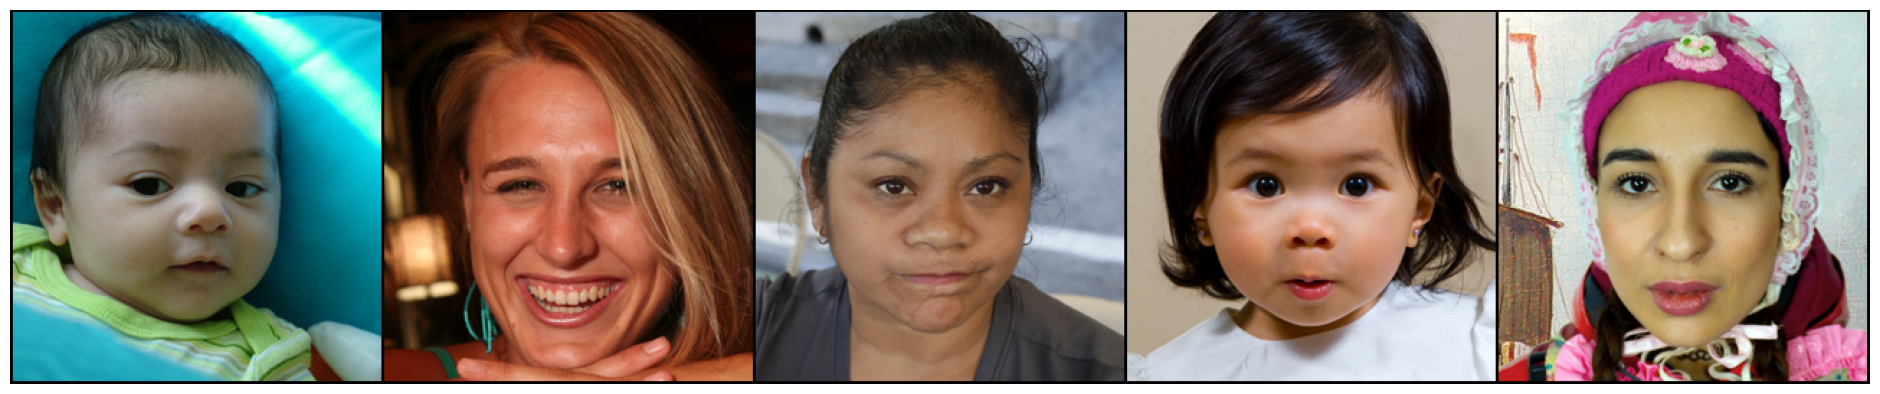

In [13]:
from data import get_dataset
from forward_operator import get_operator
from torchvision.utils import save_image
from pathlib import Path
import matplotlib.pyplot as plt
import PIL

def safe_dir(dir):
    if not Path(dir).exists():
        Path(dir).mkdir()
    return Path(dir)


def norm_image_01(x):
    return (x * 0.5 + 0.5).clip(0, 1)


def visualize_pil(target, figsize=None):
    pil_image = PIL.Image.open(target)
    if figsize is None:
        plt.figure(figsize=(24, 24))
    else:
        plt.figure(figsize=figsize)
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()


def visualize_grid(images, target='image.png', nrow=10, figsize=None, normalize=True):
    # Save images.
    save_grid(images, target, nrow=nrow, normalize=normalize)
    visualize_pil(target, figsize=figsize)


def save_grid(images, target='image.png', nrow=10, normalize=True):
    # Save images.
    if normalize:
        images = norm_image_01(images)
    save_image(images, target, nrow=nrow)

dataset = get_dataset(**data_config)
images = dataset.get_data(5)
visualize_grid(images, nrow=10)

operator = get_operator(**operator_config)
measurement = operator.measure(images)

## 2. Load diffusion model

In [14]:
from model import get_model
from sampler import get_sampler
from eval import get_eval_fn, Evaluator

model = get_model(**model_config)
sampler = get_sampler(**sampler_config, mcmc_sampler_config=mcmc_sampler_config)

eval_fn_list = []
for eval_fn_name in ['psnr', 'lpips']:
    eval_fn_list.append(get_eval_fn(eval_fn_name))
evaluator = Evaluator(eval_fn_list)

/scratch/imaging/projects/bingliang/miniconda3/envs/DAPS-test/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/imaging/projects/bingliang/miniconda3/envs/DAPS-test/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3. (Optional) unconditional generation

We simply use the same scheduler config of annealing scheduler for unconditional generation

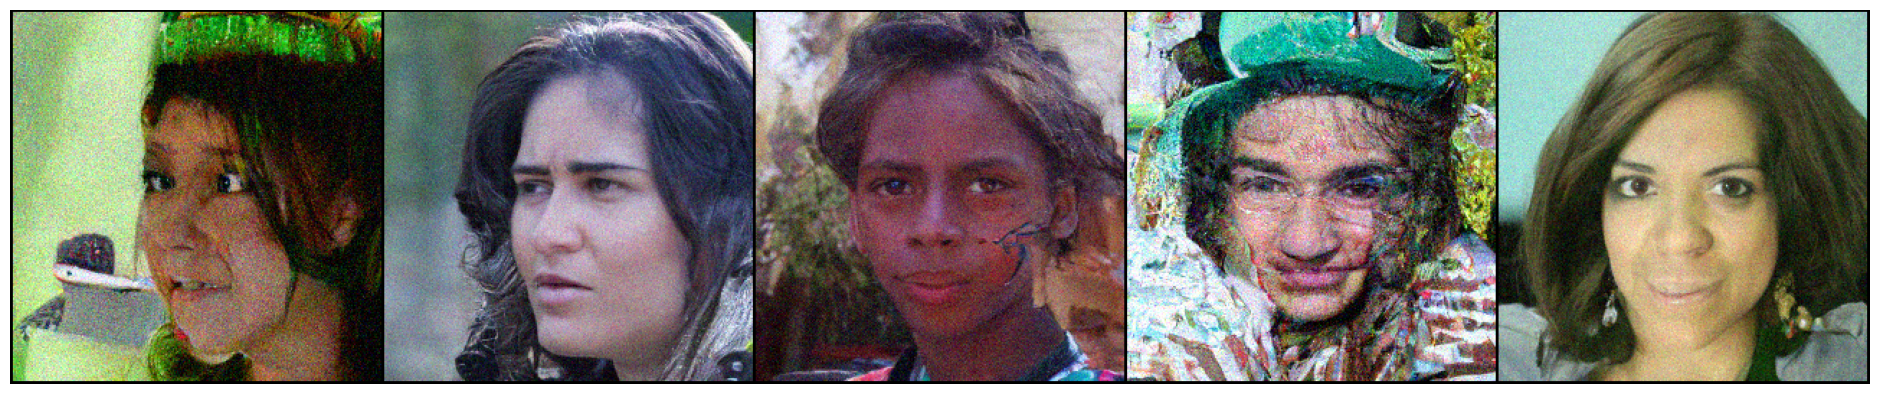

In [7]:
from cores.scheduler import get_diffusion_scheduler, DiffusionPFODE
import torch

pf_ode = DiffusionPFODE(model, get_diffusion_scheduler(**sampler_config.annealing_scheduler_config))
if sampler_config.latent:
    with torch.no_grad():
        zT = pf_ode.get_start(5)
        z0 = pf_ode.sample(zT)
        x0 = model.decode(z0)
else:
    with torch.no_grad():
        xT = pf_ode.get_start(5)
        x0 = pf_ode.sample(xT)
visualize_grid(x0, nrow=5)

## 4. Posterior sampling with DAPS
This might take few minutes to hours depends on the tasks and diffusion models.

In [16]:
daps_start = sampler.get_start(images.shape[0], model)
# gt is used only for evaluation during sampling process
samples = sampler.sample(model, daps_start, operator, measurement, evaluator, record=True, verbose=True, gt=images)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:26<00:00,  1.37it/s, x0hat_psnr=30.86, x0y_psnr=30.15]


## 5. Visualize the posterior samples
* *First row*: the ground truth source images
* *Second row*: the (resized / normalized) measurement data
* *Third row*: the posterior sample from DAPS

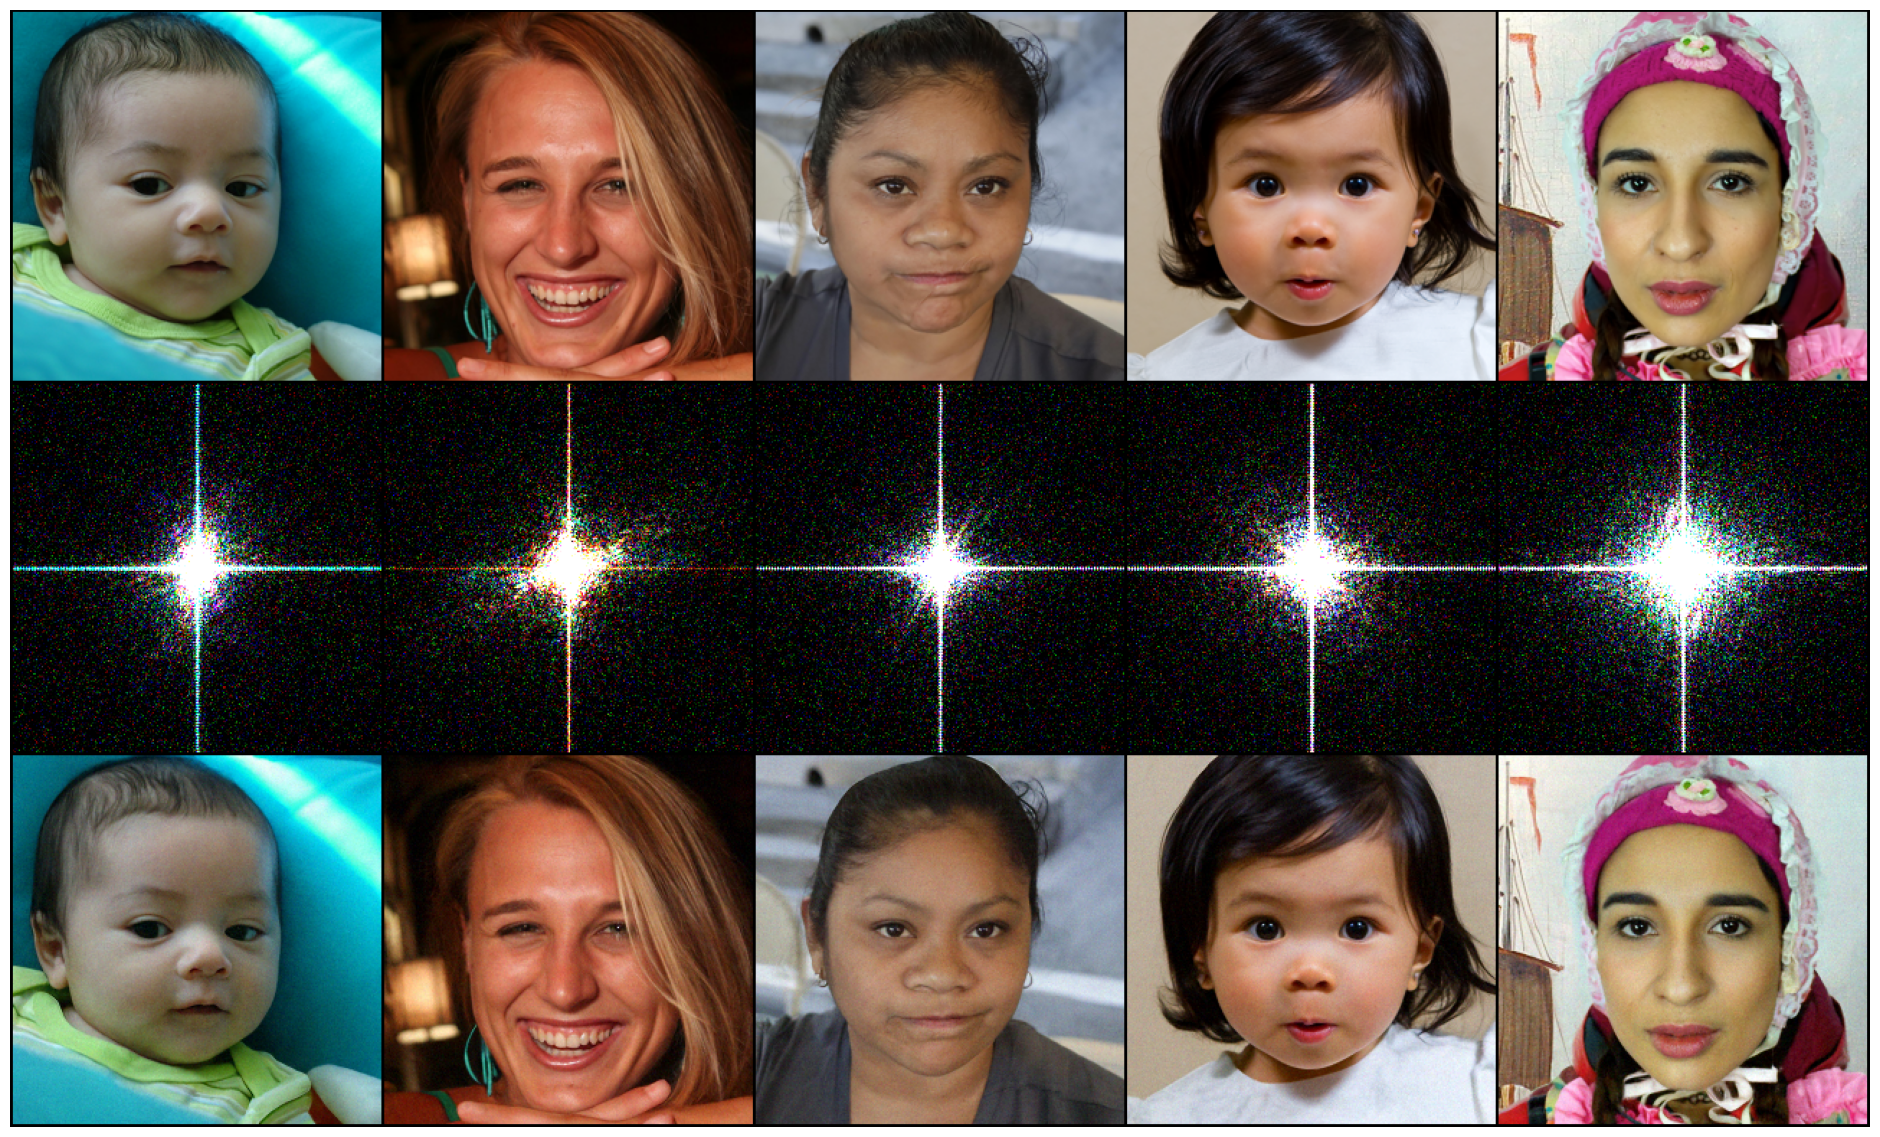

In [17]:
from torch.nn.functional import interpolate

def resize(y, x, task_name):
    if y.shape != x.shape:
        ry = interpolate(y, size=x.shape[-2:], mode='bilinear', align_corners=False)
    else:
        ry = y
    if task_name == 'phase_retrieval':
        def norm_01(y):
            tmp = (y - y.mean()) / y.std()
            tmp = tmp.clip(-0.5, 0.5) * 3
            return tmp

        ry = norm_01(ry) * 2 - 1
    return ry

resized_measurement = resize(measurement, images, operator_config.name)
stack = torch.cat([images, resized_measurement, samples])
visualize_grid(stack, nrow=5)

## 6. Analysis the sampling trajectory
* *First column*: the (resized / normalized) measurement data
* *Second column*: the ground truth source image
* *Third column*: the $x_{0\mid y}$ trajectory
* *Fourth column*: the $\hat x_0(x_t)$ trajectory
* *Fifth column*: the $x_t$ trajectory

In [ ]:
from posterior_sample import save_mp4_video
from IPython.display import Video

trajectory = sampler.trajectory.compile()
x0hat_traj = trajectory.tensor_data['x0hat']
x0y_traj = trajectory.tensor_data['x0y']
xt_traj = trajectory.tensor_data['xt']

video_path = str('trajectory.mp4')
idx = 3
save_mp4_video(images[idx], resized_measurement[idx], x0hat_traj[:, idx], x0y_traj[:, idx], xt_traj[:, idx], video_path, fps=12)

Video(video_path)